### LightGBMを試す


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'a_mean_age':                  'int8',
 'a_std_age':                   'float16',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int16',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int16',
 'perceived_colour_value_id':   'int16',
 'perceived_colour_master_id':  'int16',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'is_for_male':                 'bool',
 'is_for_female':               'bool',
 'is_for_mama':                 'bool',
 'c_mean_price':                'float16',
 'c_std_price':                 'float16',
 'a_mean_price':                'float16',     
 'c_cv_total':                  'int16',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int16',
 'a_cv_recent':                 'int32',
 'a_cv_recent_on':              'int32',
 'a_cv_recent_off':             'int32',
 'a_cv_recent2':                'int32',
 'a_cv_recent_ratio':           'float16',
 'a_cv_recent_ranking':         'int16',
 'a_cv_recent_ranking2':        'int16',
 'c_mean_sales_channel_id':     'float16',
 'a_mean_sales_channel_id':     'float16',
 'c_mean_is_for_male':          'float16',
 'a_mean_is_for_male':          'float16',
 'c_mean_is_for_female':        'float16',
 'a_mean_is_for_female':        'float16',
 'c_mean_is_for_mama':          'float16',
 'diff_dat_last_buy':           'int16',
 'a_mean_is_for_mama':          'float16',
 'ca_index_group_no_num':       'int16',
 'index_group_no_similarity':   'float16',
 'ca_index_code_num':           'int16',
 'index_code_similarity':       'float16',
 'ca_product_group_no_num':     'int16',
 'product_group_no_similarity': 'float16',
 'buy_same_before':             'int16',
 'buy_same_before_recent':      'int16',
 'buy_same_last_week':          'int16',
 'buy_rank1_before':             'int16',
 'buy_rank2_before':             'int16',
 'diff_dat_last_buy_rank1':      'int16',
 'diff_dat_last_buy_rank2':      'int16',
 'delta_mean_price':            'float16',
 'delta_mean_age':              'int8',
 'delta_mean_sales_channel_id': 'float16',
 'delta_mean_is_for_male':      'float16',
 'delta_mean_is_for_female':    'float16',
 'delta_mean_is_for_mama':      'float16',
 'match_rank':                  'int8',
 'als_rank':                    'uint8',
 'match_len':                   'int8'
 }

In [4]:
# train data
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09']
#train_date_list = ['2020-09-09', '2020-09-16']
#train_date_list = ['2020-09-09']
train_date_list = ['2020-09-16']
train_list = [dd.read_csv(f'./train_{date}.csv', dtype=input_type).compute() for date in train_date_list]

In [5]:
train = pd.concat([train_list[0]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
#valid = train_list[3].reset_index(drop=True)

In [6]:
# 毎回同じbaselineと比較するため固定
valid = dd.read_csv(f'./train_2020-09-16.csv', dtype=input_type).compute() 
#valid = dd.read_csv(f'./train_2020-09-09.csv', dtype=input_type).compute() 
valid = valid.reset_index(drop=True)

In [7]:
train

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-216791697895142778,10,859105002,0,255,False,False,False,0,2,...,0.010979,-4,0.081055,0.111084,-0.111328,0.0,1,0,78,999
1,-216791697895142778,10,859105009,1,255,False,False,False,0,2,...,0.010094,-1,-0.043945,0.111084,-0.111328,0.0,0,0,999,999
2,-216791697895142778,10,859105004,2,255,False,False,False,0,2,...,0.011894,-2,0.066406,0.111084,-0.111328,0.0,0,0,999,999
3,-216791697895142778,10,859105006,3,255,False,False,False,0,2,...,0.010666,-4,0.146484,0.111084,-0.111328,0.0,7,0,78,999
4,-216791697895142778,10,811907011,4,255,False,False,False,0,2,...,0.006935,0,-0.258789,0.111084,-0.111328,0.0,1,0,81,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759355,-8747047206777816159,0,841383002,35,255,False,False,False,0,2,...,-0.008110,-4,-1.806641,0.000000,-1.000000,0.0,0,0,999,999
2759356,-8747047206777816159,0,894780001,36,255,False,False,False,0,2,...,-0.033539,-3,-2.000000,0.000000,-1.000000,0.0,0,0,999,999
2759357,-8747047206777816159,0,706016001,37,255,False,False,False,0,2,...,-0.032440,0,-1.845703,0.000000,-1.000000,0.0,0,0,999,999
2759358,-8747047206777816159,0,936622001,38,255,False,False,False,0,2,...,-0.025070,-5,-2.000000,0.000000,-1.000000,0.0,0,0,999,999


In [8]:
train.columns.values

array(['customer_id', 'match_len', 'article_id', 'match_rank', 'als_rank',
       'label', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'c_mean_price',
       'c_std_price', 'c_cv_total', 'c_cv_recent',
       'c_mean_sales_channel_id', 'c_mean_is_for_male',
       'c_mean_is_for_female', 'c_mean_is_for_mama', 'diff_dat_last_buy',
       'product_code', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'is_for_male',
       'is_for_female', 'is_for_mama', 'product_group_no', 'a_mean_price',
       'a_cv_total', 'a_cv_recent', 'a_cv_recent_on', 'a_cv_recent_off',
       'a_cv_recent2', 'a_cv_recent_ranking', 'a_cv_recent_ranking2',
       'a_cv_recent_ratio', 'a_mean_sales_channel_id', 'a_mean_age',
       'a_std_age', 'ca_index_group_no_num', 'index_group_no_sim

In [9]:
valid

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-216791697895142778,10,859105002,0,255,False,False,False,0,2,...,0.010979,-4,0.081055,0.111084,-0.111328,0.0,1,0,78,999
1,-216791697895142778,10,859105009,1,255,False,False,False,0,2,...,0.010094,-1,-0.043945,0.111084,-0.111328,0.0,0,0,999,999
2,-216791697895142778,10,859105004,2,255,False,False,False,0,2,...,0.011894,-2,0.066406,0.111084,-0.111328,0.0,0,0,999,999
3,-216791697895142778,10,859105006,3,255,False,False,False,0,2,...,0.010666,-4,0.146484,0.111084,-0.111328,0.0,7,0,78,999
4,-216791697895142778,10,811907011,4,255,False,False,False,0,2,...,0.006935,0,-0.258789,0.111084,-0.111328,0.0,1,0,81,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759355,-8747047206777816159,0,841383002,35,255,False,False,False,0,2,...,-0.008110,-4,-1.806641,0.000000,-1.000000,0.0,0,0,999,999
2759356,-8747047206777816159,0,894780001,36,255,False,False,False,0,2,...,-0.033539,-3,-2.000000,0.000000,-1.000000,0.0,0,0,999,999
2759357,-8747047206777816159,0,706016001,37,255,False,False,False,0,2,...,-0.032440,0,-1.845703,0.000000,-1.000000,0.0,0,0,999,999
2759358,-8747047206777816159,0,936622001,38,255,False,False,False,0,2,...,-0.025070,-5,-2.000000,0.000000,-1.000000,0.0,0,0,999,999


In [10]:
del train_list
gc.collect()

0

## Preprocess

In [11]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-216791697895142778,10,859105002,0,255,False,False,False,0,2,...,0.010979,-4,0.081055,0.111084,-0.111328,0.0,1,0,78,999
1,-216791697895142778,10,859105009,1,255,False,False,False,0,2,...,0.010094,-1,-0.043945,0.111084,-0.111328,0.0,0,0,999,999
2,-216791697895142778,10,859105004,2,255,False,False,False,0,2,...,0.011894,-2,0.066406,0.111084,-0.111328,0.0,0,0,999,999
3,-216791697895142778,10,859105006,3,255,False,False,False,0,2,...,0.010666,-4,0.146484,0.111084,-0.111328,0.0,7,0,78,999
4,-216791697895142778,10,811907011,4,255,False,False,False,0,2,...,0.006935,0,-0.258789,0.111084,-0.111328,0.0,1,0,81,999


In [12]:
# queryの準備, customer_idごとにsortする, lightGBMを使うときに必要
query_list_train = train['customer_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid['customer_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [13]:
query_list_train.head()

-9223100958908512198    40
-9223002534477110135    40
-9222810895170663723    40
-9221924794303263774    40
-9221811157628158522    40
Name: customer_id, dtype: int64

In [14]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [15]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

In [16]:
# labelエンコードは前段で済んでいる

## Training

In [17]:
# LightGBM
import lightgbm as lgb # Hypter parameter tuningしない場合
#import optuna.integration.lightgbm as lgb # 勝手にHypter paramterの探索までやってくれる

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    #'ndcg_eval_at': [12],
    'map_eval_at': [12],
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
}

num_round = 120

In [18]:
# Optuna results top 40 params
params = {'objective': 'lambdarank',
 'metric': 'map',
 'map_eval_at': [12],
 'num_leaves': 251,
 'learning_rate': 0.01,
 'feature_fraction': 0.5,
 'bagging_freq': 1,
 'bagging_fraction': 0.8,
 'random_state': 0,
 'feature_pre_filter': False,
 'lambda_l1': 7.915132769532289,
 'lambda_l2': 3.052856579659528e-06,
 'min_data_in_leaf': 100,
 'min_child_samples': 10,
 'num_iterations': 120,
 'early_stopping_round': 20}

In [19]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

In [20]:
lgb_train

In [21]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval],
                  #callbacks=[early_stopping(10), log_evaluation(10)],
                  early_stopping_rounds=20
                 )

/home/tetsuro/.local/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/tetsuro/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Total groups: 68984, total data: 2759360
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9392
[LightGBM] [Info] Number of data points in the train set: 2759360, number of used features: 64
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Total groups: 68984, total data: 2759360
[1]	train's map@12: 0.8416	valid's map@12: 0.8416
Training until validation scores don't improve for 20 rounds
[2]	train's map@12: 0.850304	valid's map@

In [22]:
model.params

{'objective': 'lambdarank',
 'metric': 'map',
 'map_eval_at': [12],
 'num_leaves': 251,
 'learning_rate': 0.01,
 'feature_fraction': 0.5,
 'bagging_freq': 1,
 'bagging_fraction': 0.8,
 'random_state': 0,
 'feature_pre_filter': False,
 'lambda_l1': 7.915132769532289,
 'lambda_l2': 3.052856579659528e-06,
 'min_data_in_leaf': 100,
 'min_child_samples': 10,
 'num_iterations': 120,
 'early_stopping_round': 20}

In [23]:
model.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x7f8cb64e7bb0>>

In [24]:
model.best_iteration

120

In [25]:
model.feature_name()

['match_len',
 'match_rank',
 'als_rank',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'c_mean_price',
 'c_std_price',
 'c_cv_total',
 'c_cv_recent',
 'c_mean_sales_channel_id',
 'c_mean_is_for_male',
 'c_mean_is_for_female',
 'c_mean_is_for_mama',
 'diff_dat_last_buy',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'is_for_male',
 'is_for_female',
 'is_for_mama',
 'product_group_no',
 'a_mean_price',
 'a_cv_total',
 'a_cv_recent',
 'a_cv_recent_on',
 'a_cv_recent_off',
 'a_cv_recent2',
 'a_cv_recent_ranking',
 'a_cv_recent_ranking2',
 'a_cv_recent_ratio',
 'a_mean_sales_channel_id',
 'a_mean_age',
 'a_std_age',
 'ca_index_group_no_num',
 'index_group_no_similarity',
 'ca_index_code_num',
 'index_code_similarity',
 'ca_product_group_no_num',
 'product_

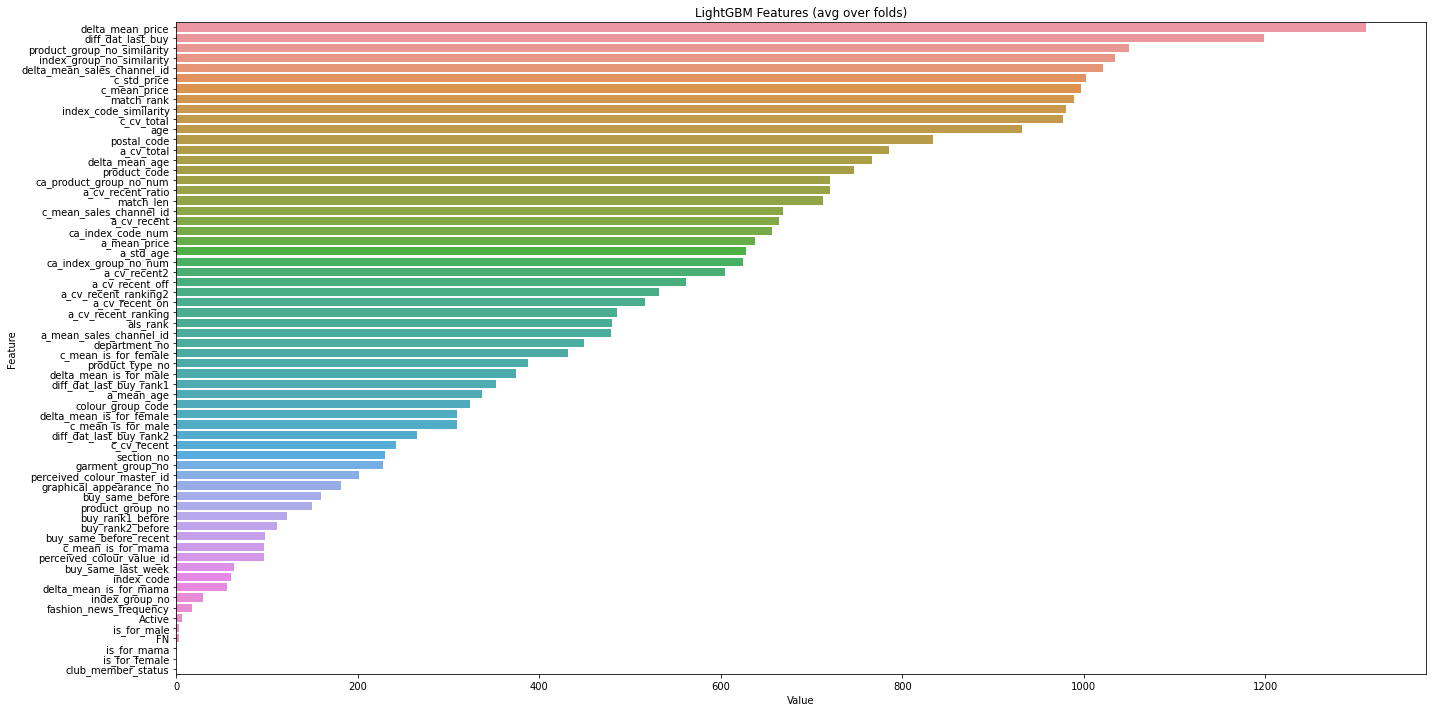

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## test

In [27]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

15484

In [28]:
# test data
#Nval = 12
test = dd.read_csv(f'./test.csv', dtype=input_type).compute()
#test = dd.read_csv(f'./test_2020-09-16.csv', dtype=input_type).compute()
test

,customer_id,match_len,article_id,match_rank,als_rank,FN,Active,club_member_status,fashion_news_frequency,age,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-2324495172285268445,6,736530007,0,255,True,False,0,4,21,...,-0.000458,-9,0.287109,0.0,0.0,0.0,0,0,999,999
1,-2324495172285268445,6,770703004,1,255,True,False,0,4,21,...,-0.005844,-12,0.236328,0.0,0.0,0.0,0,0,999,999
2,-2324495172285268445,6,736531006,2,255,True,False,0,4,21,...,0.014046,-10,0.303711,0.0,0.0,0.0,1,0,299,999
3,-2324495172285268445,6,706016001,3,255,True,False,0,4,21,...,-0.008728,-11,0.154297,0.0,0.0,0.0,1,0,299,999
4,-2324495172285268445,6,611415005,4,255,True,False,0,4,21,...,0.007523,-10,0.360352,0.0,0.0,0.0,0,1,999,299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114346,-3280349465215843523,6,711053003,35,255,False,False,0,2,25,...,0.048035,-8,-0.525391,0.0,0.0,0.0,0,0,999,999
114347,-3280349465215843523,6,904571001,36,255,False,False,0,2,25,...,0.019897,-8,-0.728516,0.0,0.0,0.0,0,0,999,999
114348,-3280349465215843523,6,925404001,37,255,False,False,0,2,25,...,-0.004425,-9,-0.575195,0.0,0.0,0.0,0,0,999,999
114349,-3280349465215843523,6,896170012,38,255,False,False,0,2,25,...,0.044739,-5,0.000000,0.0,0.0,0.0,0,0,999,999


In [29]:
test.sort_index(inplace=True)

In [30]:
test_id = test[['customer_id', 'article_id']]
test = test.drop(['customer_id', 'article_id'], axis=1)

### prediction

In [31]:
del query_list_train, query_list_valid, lgb_train, lgb_eval, params, feature_imp
gc.collect()

0

In [32]:
test

,match_len,match_rank,als_rank,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,6,0,255,True,False,0,4,21,183703,0.023712,...,-0.000458,-9,0.287109,0.000000,0.000000,0.0,0,0,999,999
0,4,6,255,False,False,0,2,38,235177,0.037048,...,0.003693,3,0.175781,0.013512,-0.013672,0.0,0,0,999,999
0,10,1,255,True,True,0,4,57,298287,0.025406,...,0.009308,21,0.033203,0.000000,-0.090820,0.0,0,0,999,999
0,6,9,255,False,False,0,2,55,69650,0.026077,...,-0.007401,12,0.113281,0.000000,0.000000,0.0,0,0,999,999
0,3,14,255,False,False,0,2,52,38421,0.033020,...,0.008133,16,-0.614258,0.350098,-0.350098,0.0,0,0,999,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114588,13,8,39,False,False,0,2,53,208399,0.032837,...,-0.000336,14,-0.572266,0.222168,-0.222168,0.0,0,1,999,6
114589,13,9,17,False,False,0,2,53,208399,0.032837,...,-0.015381,15,-0.259766,0.222168,-0.222168,0.0,0,1,999,6
114590,13,10,255,False,False,0,2,53,208399,0.032837,...,0.026276,23,0.025391,0.222168,-0.222168,0.0,2,1,77,6
114591,13,11,255,False,False,0,2,53,208399,0.032837,...,0.024750,18,-0.628906,0.222168,-0.222168,0.0,2,5,364,6


In [33]:
test.columns.values

array(['match_len', 'match_rank', 'als_rank', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age',
       'postal_code', 'c_mean_price', 'c_std_price', 'c_cv_total',
       'c_cv_recent', 'c_mean_sales_channel_id', 'c_mean_is_for_male',
       'c_mean_is_for_female', 'c_mean_is_for_mama', 'diff_dat_last_buy',
       'product_code', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'is_for_male',
       'is_for_female', 'is_for_mama', 'product_group_no', 'a_mean_price',
       'a_cv_total', 'a_cv_recent', 'a_cv_recent_on', 'a_cv_recent_off',
       'a_cv_recent2', 'a_cv_recent_ranking', 'a_cv_recent_ranking2',
       'a_cv_recent_ratio', 'a_mean_sales_channel_id', 'a_mean_age',
       'a_std_age', 'ca_index_group_no_num', 'index_group_no_similarity',
       'ca_index_code_num', 'index_

In [34]:
Nrow = 55000000
Ndiv = 10
n = Nrow // Ndiv
test_list = []
for i in range(Ndiv):
    tmp = test.iloc[i*n : (i+1)*n, :]
    test_list.append(tmp)

In [35]:
del test
gc.collect()

0

In [36]:
pred_list = [] 
for i, v in enumerate(test_list):
    print('i=', i)
    tmp = model.predict(v, num_iteration=model.best_iteration)
    pred_list.append(tmp) 

del test_list
gc.collect()

i= 0
i= 1
i= 2
i= 3
i= 4
i= 5
i= 6
i= 7
i= 8
i= 9


40

In [37]:
pred_list

[array([-0.33949501, -0.10839194, -0.89304139, ..., -0.10908101,
        -0.30680678, -0.00370966]),
 array([-0.26837653, -0.44191194,  0.15392673, ..., -0.36839006,
        -0.28917809, -0.13480606]),
 array([-0.28902131, -0.36522571,  0.16712942, ..., -0.09925777,
        -0.07252197, -0.5984228 ]),
 array([-0.14308827, -0.43621907, -0.62048424, ..., -0.18533576,
        -0.33398744, -0.09768704]),
 array([-0.20459215,  0.46858319, -0.21616846, ..., -0.0533664 ,
        -0.22044237, -0.3756434 ]),
 array([-0.57112625, -0.26487854, -0.28934315, ...,  0.08923736,
        -0.49030911, -0.19693011]),
 array([-0.47571108, -0.05949994, -0.41662122, ..., -0.42467982,
        -0.45306854, -0.06682635]),
 array([-0.98417086, -0.10210233, -0.07519946, ..., -0.3268052 ,
        -0.38517739, -0.42190186]),
 array([-0.28782641, -0.11616485, -0.34773881, ..., -0.21408624,
        -0.21297469, -0.64159822]),
 array([-0.35666472, -0.32579333, -0.093028  , ..., -0.68372364,
        -0.52347012, -0.00

In [38]:
pred = np.concatenate(pred_list)
pred

array([-0.33949501, -0.10839194, -0.89304139, ..., -0.68372364,
       -0.52347012, -0.00686826])

In [39]:
del pred_list
gc.collect()

0

In [40]:
#pred = model.predict(test, num_iteration=model.best_iteration)
#pred.shape, test.shape

In [41]:
#del test, model
del model
gc.collect()

0

In [42]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [43]:
sub1 = pd.concat([test_id, pred], axis=1)

In [44]:
#sub1 = sub1[['customer_id', 'article_id', 'score']]

In [45]:
sub1

,customer_id,article_id,score
0,-2324495172285268445,736530007,-0.339495
1,-1157441420060012207,915529003,-0.108392
2,-6903746001451913977,841260008,-0.893041
3,-3053321454219994633,928206001,-0.159211
4,-7450517975994766338,889460003,-0.093216
...,...,...,...
54879195,-7697935768523359560,751471039,-0.040590
54879196,-7697935768523359560,578476001,-0.030811
54879197,-7697935768523359560,156231001,-0.683724
54879198,-7697935768523359560,610776002,-0.523470


In [46]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [47]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [48]:
sub1['prediction'].apply(len)

0          40
1          40
2          40
3          40
4          40
           ..
1371975    40
1371976    40
1371977    40
1371978    40
1371979    40
Name: prediction, Length: 1371980, dtype: int64

In [49]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0          12
1          12
2          12
3          12
4          12
           ..
1371975    12
1371976    12
1371977    12
1371978    12
1371979    12
Name: prediction, Length: 1371980, dtype: int64

In [50]:
sub1['prediction']

0          [706016001, 673396002, 924243001, 918522001, 8...
1          [910601003, 910601003, 908292002, 903926001, 9...
2          [610776002, 930380003, 930380001, 751471001, 7...
3          [715624001, 762846027, 448509014, 562245046, 7...
4          [924243001, 751471001, 924243002, 751471043, 9...
                                 ...                        
1371975    [706016001, 448509014, 714790020, 751471001, 8...
1371976    [658030020, 918292001, 658030011, 706016001, 9...
1371977    [714790020, 923758001, 867969003, 919273002, 9...
1371978    [930380001, 924243001, 930380003, 850917001, 6...
1371979    [781758003, 781758001, 924243001, 919273002, 8...
Name: prediction, Length: 1371980, dtype: object

In [51]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [52]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0673396002 0924243001 0918522001 08...
1,-9223343869995384291,0910601003 0910601003 0908292002 0903926001 09...
2,-9223321797620987725,0610776002 0930380003 0930380001 0751471001 07...
3,-9223319430705797669,0715624001 0762846027 0448509014 0562245046 07...
4,-9223308614576639426,0924243001 0751471001 0924243002 0751471043 09...
...,...,...
1371975,9223319300843860958,0706016001 0448509014 0714790020 0751471001 08...
1371976,9223333063893176977,0658030020 0918292001 0658030011 0706016001 09...
1371977,9223345314868180224,0714790020 0923758001 0867969003 0919273002 09...
1371978,9223357421094039679,0930380001 0924243001 0930380003 0850917001 06...


## Submit

In [53]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [54]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [55]:
print(sub.shape, sub1.shape)

(1371980, 2) (1371980, 2)


In [56]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [57]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0673396002 0924243001 0918522001 08...
1,-9223343869995384291,0910601003 0910601003 0908292002 0903926001 09...
2,-9223321797620987725,0610776002 0930380003 0930380001 0751471001 07...
3,-9223319430705797669,0715624001 0762846027 0448509014 0562245046 07...
4,-9223308614576639426,0924243001 0751471001 0924243002 0751471043 09...
...,...,...
1371975,9223319300843860958,0706016001 0448509014 0714790020 0751471001 08...
1371976,9223333063893176977,0658030020 0918292001 0658030011 0706016001 09...
1371977,9223345314868180224,0714790020 0923758001 0867969003 0919273002 09...
1371978,9223357421094039679,0930380001 0924243001 0930380003 0850917001 06...


In [58]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [59]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [60]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0568601043 0924243001 0915529003 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0924243001 0918522001 0915529005 0673677002 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0794321011 0924243001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0867969003 0762846027 0751471001 0720125001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0924243001 0918522001 0896152001 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0611415001 0791587001 0924243001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846008 0448509014 0762846031 0894780001 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846006 0762846027 0706016002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0894780001 0788575004 09...


In [61]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission_lgbm.csv', index=False)
#sub.to_csv('submission_lgbm_test.csv', index=False)

(1371980, 2)
